In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest as smm

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from scripts.utils import loadcsv

# BOX 箱型图

In [2]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()

for stain_type in ["H3K27ac", "CTCF"]:
    for sl in ["SR", "LR"]:
        loadpath = f"/home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_{sl}"
        loadpath_RETT = f"{loadpath}/RETT_HPS9999_{stain_type}_metrics_basic.csv"
        loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_metrics_basic.csv"
        
        df_combined, df_RETT, df_CTRL = loadcsv(loadpath_RETT, loadpath_CTRL)
        
        df_combined['Stain_Type'] = f"{stain_type}_{sl}"  # 添加染色类型列
        
        data_all = pd.concat([data_all, df_combined])  # 合并数据

data_all.head(2)

LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/RETT_HPS9999_H3K27ac_metrics_basic.csv (3590, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/CTRL_H3K27ac_metrics_basic.csv (1719, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_LR/RETT_HPS9999_H3K27ac_metrics_basic.csv (3592, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_LR/CTRL_H3K27ac_metrics_basic.csv (1722, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/RETT_HPS9999_CTCF_metrics_basic.csv (3593, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/CTRL_CTCF_metrics_basic.csv (1722, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_LR/RETT_HPS9999_CTCF_metrics_basic.csv (3595, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_LR/CTRL_CTCF_metrics_b

,chromatin_num,chromatin_area,chromatin_intensity,chromatin_shape,nuclear_area,nuclear_intensity,chromatin_distribution_part1,chromatin_distribution_part2,chromatin_distribution_part3,chromatin_distribution_part4,chromatin_distribution_part5,RCA-S,RCA-M,RCI-S,RCI-M,State,Stain_Type
0,111,22.297297,19.777882,1.736908,38948,14.079465,1.244135,0.459095,0.419030,0.267380,0.480769,0.063546,0.000572,155.925307,1.404732,CTRL,H3K27ac_SR
1,133,30.819549,34.561834,1.734314,42887,25.885373,0.906149,0.727893,0.759435,0.777605,0.000000,0.095577,0.000719,177.579973,1.335188,CTRL,H3K27ac_SR


In [11]:
# deepseek validata_boxplot

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

def validata_boxplot(data_all, feature, savepath, ylim=None):
    # 设置全局绘图参数
    matplotlib.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],  # 使用通用无衬线字体
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.linewidth': 1.5,
        'pdf.fonttype': 42,
        'figure.dpi': 300,
    })
    
    # 数据清洗
    data_all = data_all.dropna(subset=[feature])
    unique_stains = ['H3K27ac_SR', 'H3K27ac_LR', 'CTCF_SR', 'CTCF_LR']
    valid_stains = [stain for stain in unique_stains 
                    if set(data_all[data_all['Stain_Type'] == stain]['State'].unique()) >= {'CTRL', 'RETT'}]
    
    if not valid_stains:
        print(f"[Skip] No valid groups for feature: {feature}")
        return

    # 创建画布和坐标轴
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 定义配色方案
    palette_colors = {"CTRL": "#4C72B0", "RETT": "#C44E52"}
    
    # 绘制箱线图
    sns.boxplot(
        x='Stain_Type',
        y=feature,
        hue='State',
        data=data_all[data_all['Stain_Type'].isin(valid_stains)],
        palette=palette_colors,
        order=valid_stains,
        width=0.7,
        linewidth=1.5,
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='none',
            markeredgecolor='black',
            markeredgewidth=0.5
        )
    )
    
    # 美化图形
    ax.spines[['right', 'top']].set_visible(False)  # 隐藏右、上边框
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')  # 添加横向虚线网格
    
    # 设置标签和标题
    ax.set_title(f'{feature}', pad=10)
    ax.set_ylabel(f'{feature}', labelpad=10)
    ax.set_xlabel('Stain Type', labelpad=10)
    
    # 调整图例位置
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='upper right',
        bbox_to_anchor=(1.02, 1),  # 图例置于图外右侧
        title='Cell State',
        title_fontsize=12
    )
    
    # 旋转X轴标签
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    
    # 设置Y轴范围
    if ylim is not None:
        plt.ylim(0, ylim)
    
    # 调整布局并保存
    plt.tight_layout(pad=2.0)
    os.makedirs(savepath, exist_ok=True)
    plt.savefig(
        f'{savepath}/{feature}.png',
        dpi=600,
        bbox_inches='tight',
        transparent=False
    )
    
    # 显示图形（关键修改点）
    plt.show()  # ✅ 添加此行以显示图形
    
    # 关闭图形（避免内存泄漏）
    plt.close()

💠 Fearure - chromatin_num


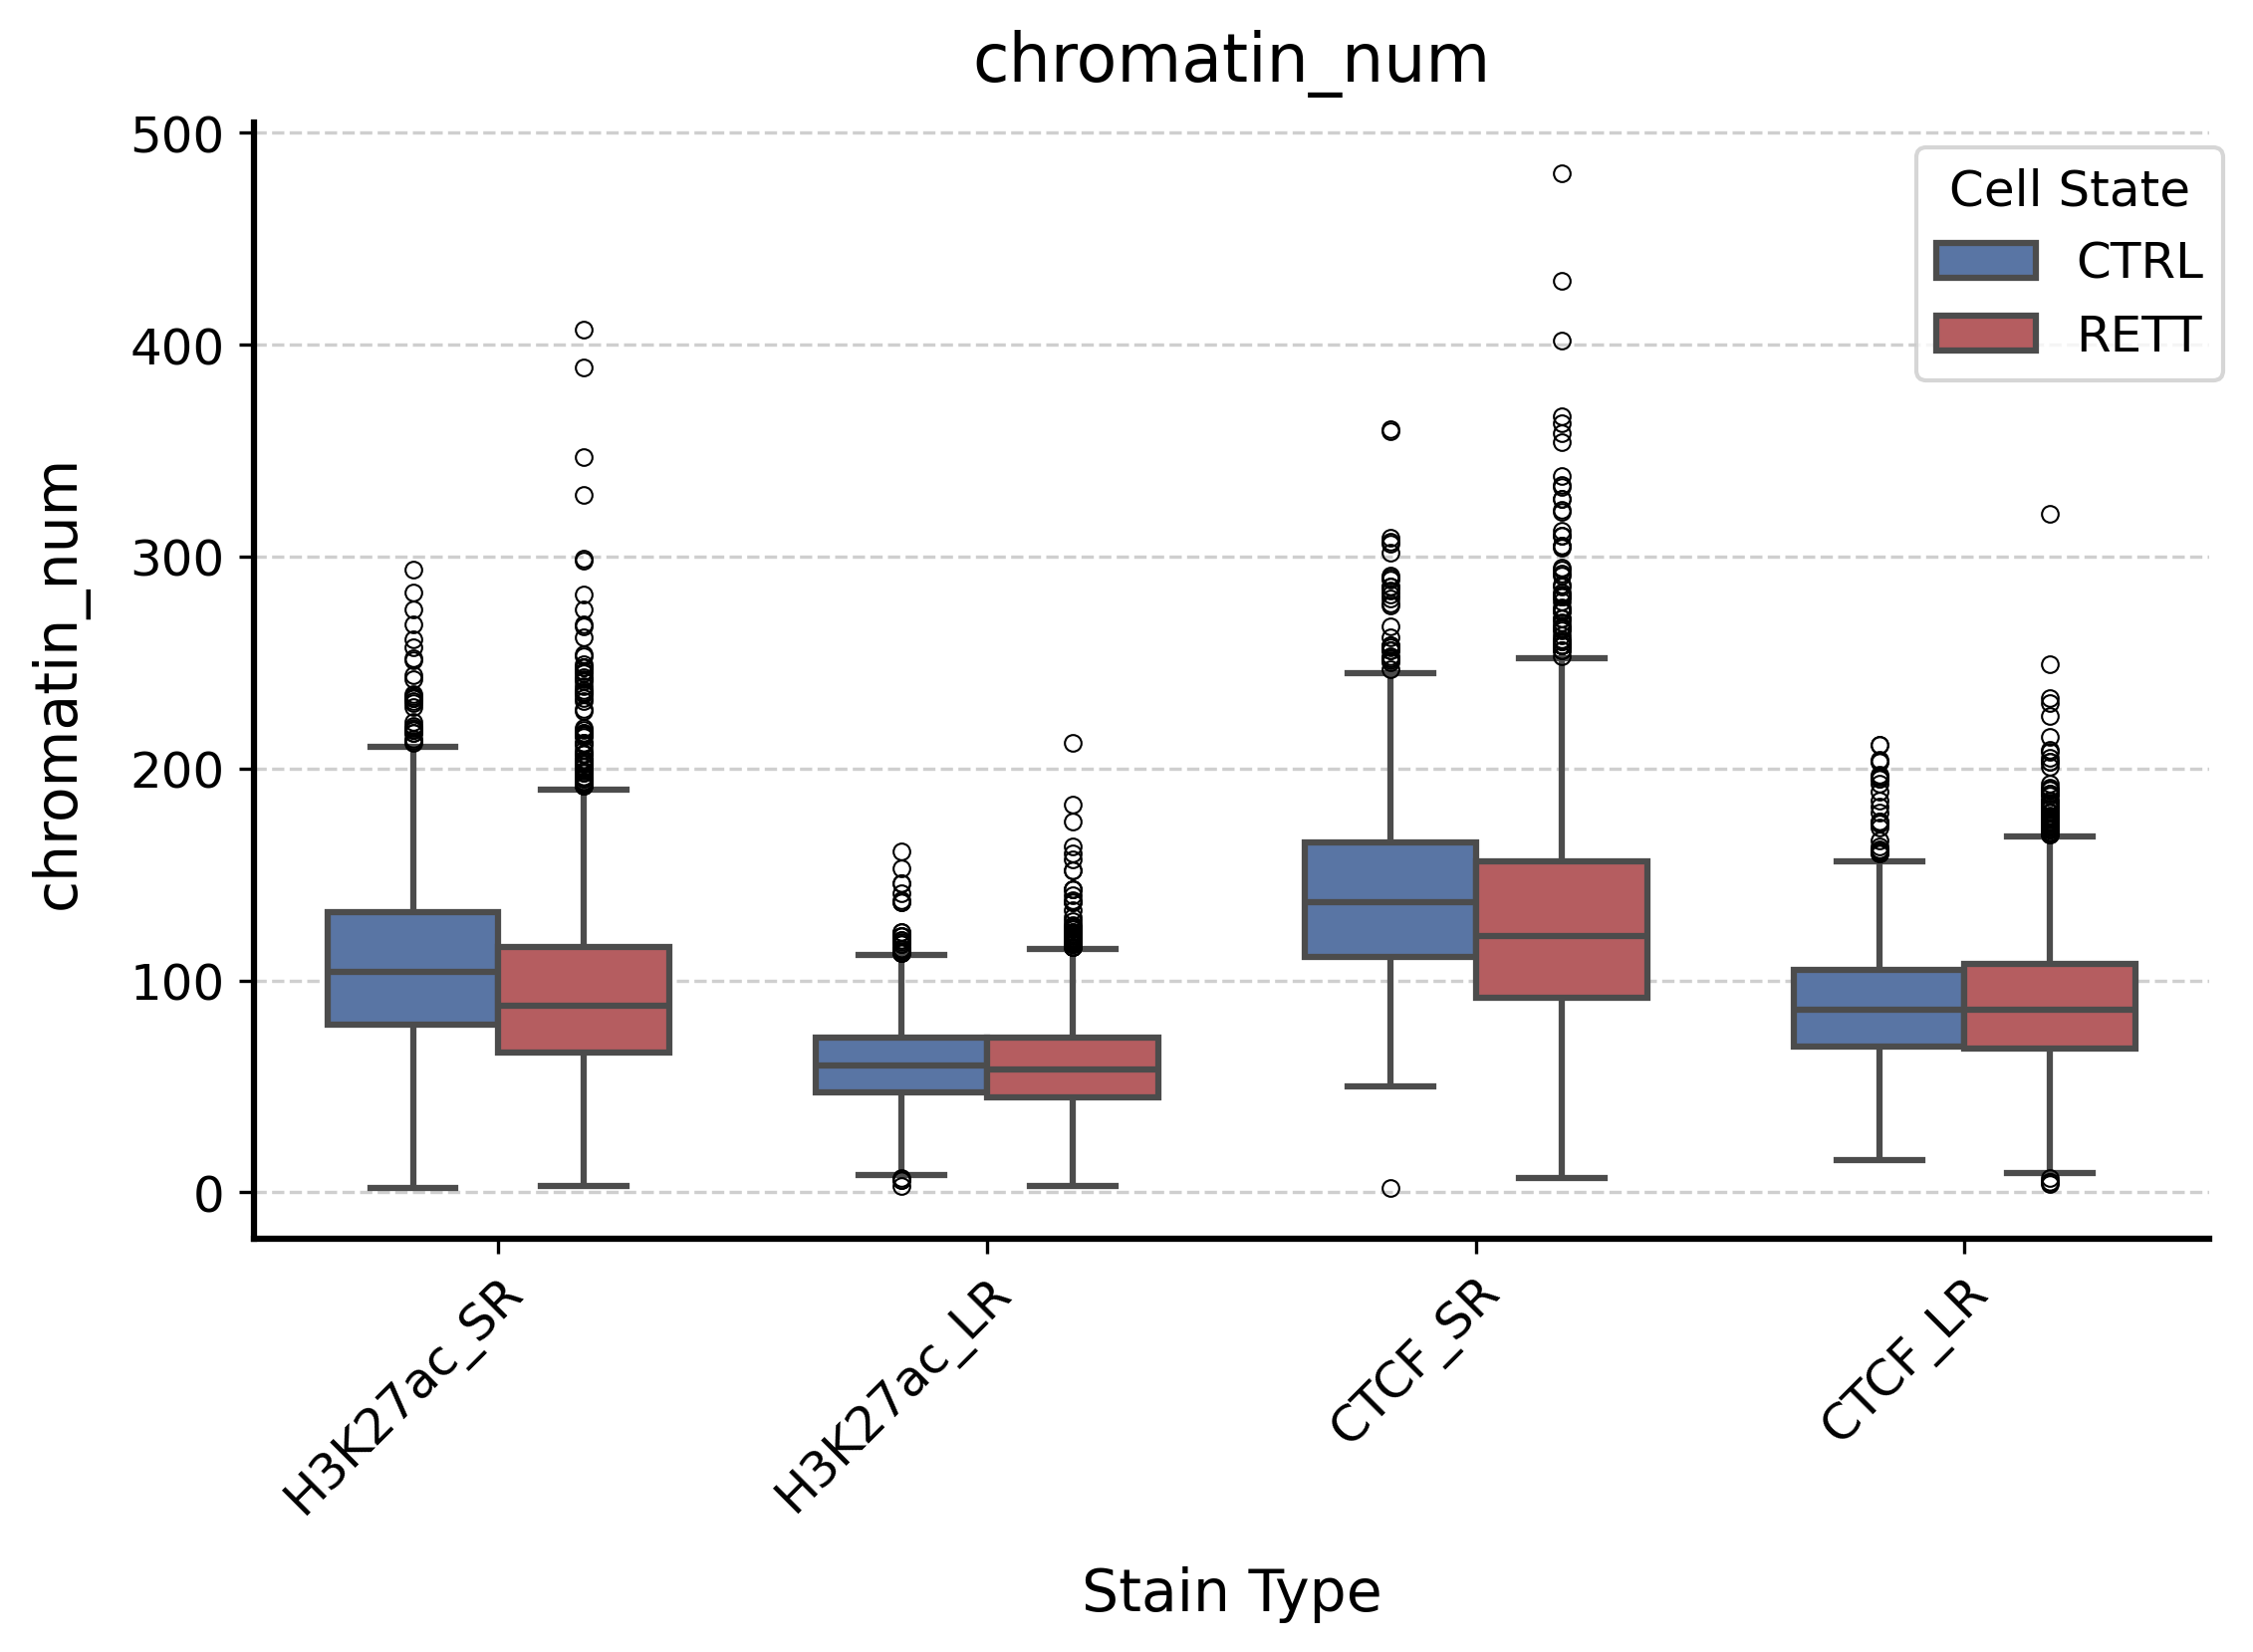

In [12]:
savepath = f"/home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_figures"
# for feature in ['chromatin_num', 'chromatin_area', 'chromatin_shape', 'chromatin_intensity', 'chromatin_distribution_part5']:
for feature in ['chromatin_num']:
    
    print(f"💠 Fearure - {feature}")
    validata_boxplot(data_all, feature, savepath)

In [4]:
# # 创建一个空的 DataFrame 用于存放所有数据
# data_all = pd.DataFrame()
# loadpath = "/home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR"

# for stain_type in ["H3K27ac", "CTCF"]:
    
#     loadpath_RETT = f"{loadpath}/RETT_HPS9999_{stain_type}_metrics_basic.csv"
#     loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_metrics_basic.csv"
    
#     savename = f"Feature_{stain_type}"
#     df_combined, df_RETT, df_CTRL = loadcsv(loadpath_RETT, loadpath_CTRL)
    
#     df_combined['Stain_Type'] = stain_type  # 添加染色类型列
#     data_all = pd.concat([data_all, df_combined])  # 合并数据

#     features = df_CTRL.columns.tolist()
#     print(features, "\n")
#     for feature in ['chromatin_num', 'chromatin_area']:
#         print(f"💠 Fearure - HPS9999 - {feature}")
#         validata_boxplot(data_all, feature, rett_type, saveto="features_chromatin")
# #         validata_violinplot(data_all, feature, rett_type, saveto="features_chromatin")

💠 Fearure - HPS9999 - chromatin_area
p-value for H3K27ac: 1.0734806083253427e-15
p-value for H3K27ac_LR: 2.3611739810051574e-61
p-value for CTCF: 1.6883634517025142e-84
p-value for CTCF_LR: 1.5718041883029372e-87


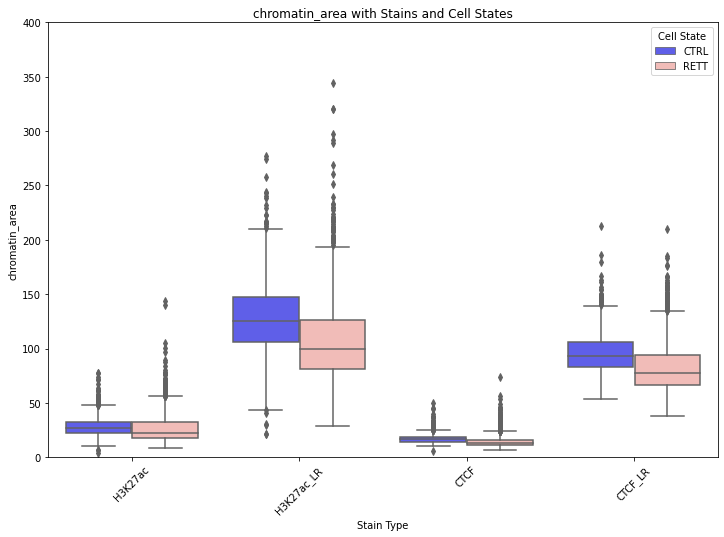

In [12]:
print(f"💠 Fearure - HPS9999 - chromatin_area")
validata_boxplot(data_all, 'chromatin_area', rett_type, saveto="features_chromatin", ylim=400)

In [9]:
import numpy as np

original_resolution = 50  # nm/px
sigma = (11 - 1) / 6
effective_resolution = np.sqrt((sigma * original_resolution)**2 + original_resolution**2)

print(f"Effective resolution after Gaussian blur: {effective_resolution:.2f} nm/px")

Effective resolution after Gaussian blur: 97.18 nm/px


# Feature image

In [7]:
# ttest

def validate_ttest(df_combined, df_RETT, df_CTRL):
    print("📊 ttest")
    # 初始化存储 p 值的列表
    p_values = []

    # 进行 t-检验
    for column in df_CTRL.columns[:-1]:  # 忽略 'State' 列
        t_stat, p_val = ttest_ind(
            df_CTRL[column], 
            df_RETT[column],
            equal_var=False  # 可以假设不等方差
        )
        p_values.append((column, p_val))

    # 将 p 值转化为 DataFrame
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    # 提取原始 p 值列表
    p_values_list = p_values_df['p_value'].tolist()

    # 进行校正
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]

    # 将校正后的 p 值添加回 DataFrame
    p_values_df['p_corrected'] = pval_corr

    # 筛选显著特征（例如校正后 p < 0.02）
    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]

    # 按 p 值排序
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     # 可视化显著特征的 p 值
#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_ttest.png', dpi=300)
#     plt.show()

In [8]:
# mannwhitneyu

def validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL):
    print("📊 Mann-Whitney U test")
    p_values = []

    for column in df_CTRL.columns[:-1]:
        stat, p_val = mannwhitneyu(df_CTRL[column], df_RETT[column], alternative='two-sided')
        p_values.append((column, p_val))

    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    p_values_list = p_values_df['p_value'].tolist()
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]
    p_values_df['p_corrected'] = pval_corr

    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_mannwhitneyutest.png', dpi=300)
#     plt.show()

In [11]:
# ttest / mannwhitneyu
# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for stain_type in ["H3K27ac", "CTCF"]:
    loadpath = "/home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR"
    loadpath_RETT = f"{loadpath}/RETT_HPS9999_{stain_type}_metrics_basic.csv"
    loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_metrics_basic.csv"
    
    savename = f"Feature_{stain_type}"
    df_combined, df_RETT, df_CTRL = loadcsv(loadpath_RETT, loadpath_CTRL)
    
    validate_ttest(df_combined, df_RETT, df_CTRL)

    # validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL)
    
    print("############################################################")
    print("")

LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/RETT_HPS9999_H3K27ac_metrics_basic.csv (3590, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/CTRL_H3K27ac_metrics_basic.csv (1719, 15)
📊 ttest
significant_features:  14
                     Feature       p_value   p_corrected
                       RCI-M 4.911487e-156 7.367231e-155
                       RCA-S 2.137954e-124 1.603465e-123
         chromatin_intensity  3.371286e-66  1.685643e-65
chromatin_distribution_part2  8.221090e-61  3.082909e-60
chromatin_distribution_part3  2.948124e-51  8.844372e-51
               chromatin_num  3.497836e-32  8.744589e-32
           nuclear_intensity  1.025257e-29  2.196979e-29
chromatin_distribution_part4  4.329563e-25  8.117931e-25
              chromatin_area  4.100404e-22  6.834006e-22
             chromatin_shape  1.901463e-19  2.852194e-19
                       RCA-M  9.602192e-19  1.309390e-18
                       R

In [6]:
# PCA

def validate_pca(df_combined, df_RETT, df_CTRL):
    print("📊 PCA")
    # 提取特征数据
    features = df_combined.drop('State', axis=1)

    # 应用 PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(features)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

    # 计算贡献率
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    # 获取加载矩阵
    loading_matrix = pca.components_.T
    loading_df = pd.DataFrame(loading_matrix, columns=['PC1', 'PC2'], index=features.columns)

    # 可视化加载矩阵
    plt.figure(figsize=(16, 12))
    sns.heatmap(loading_df, annot=True, cmap='coolwarm')
    plt.title('PCA Loading Matrix')
#     plt.savefig(f'tables/features_chromatin/PCA_Matrix_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

    # 重置索引以确保对齐
    state_df = df_combined[['State']].reset_index(drop=True)
    finalDf = pd.concat([principalDf, state_df], axis=1)

    # 使用 Seaborn 绘制 PCA 结果图
    sns.scatterplot(data=finalDf, x='principal component 1', y='principal component 2', hue='State')
    plt.title('PCA of Dataset by State')
#     plt.savefig(f'tables/features_chromatin/PCA_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/RETT_HPS9999_H3K27ac_metrics_basic.csv (3590, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/CTRL_H3K27ac_metrics_basic.csv (1719, 15)
📊 PCA
Explained variance ratio: [0.32503066 0.17528289]


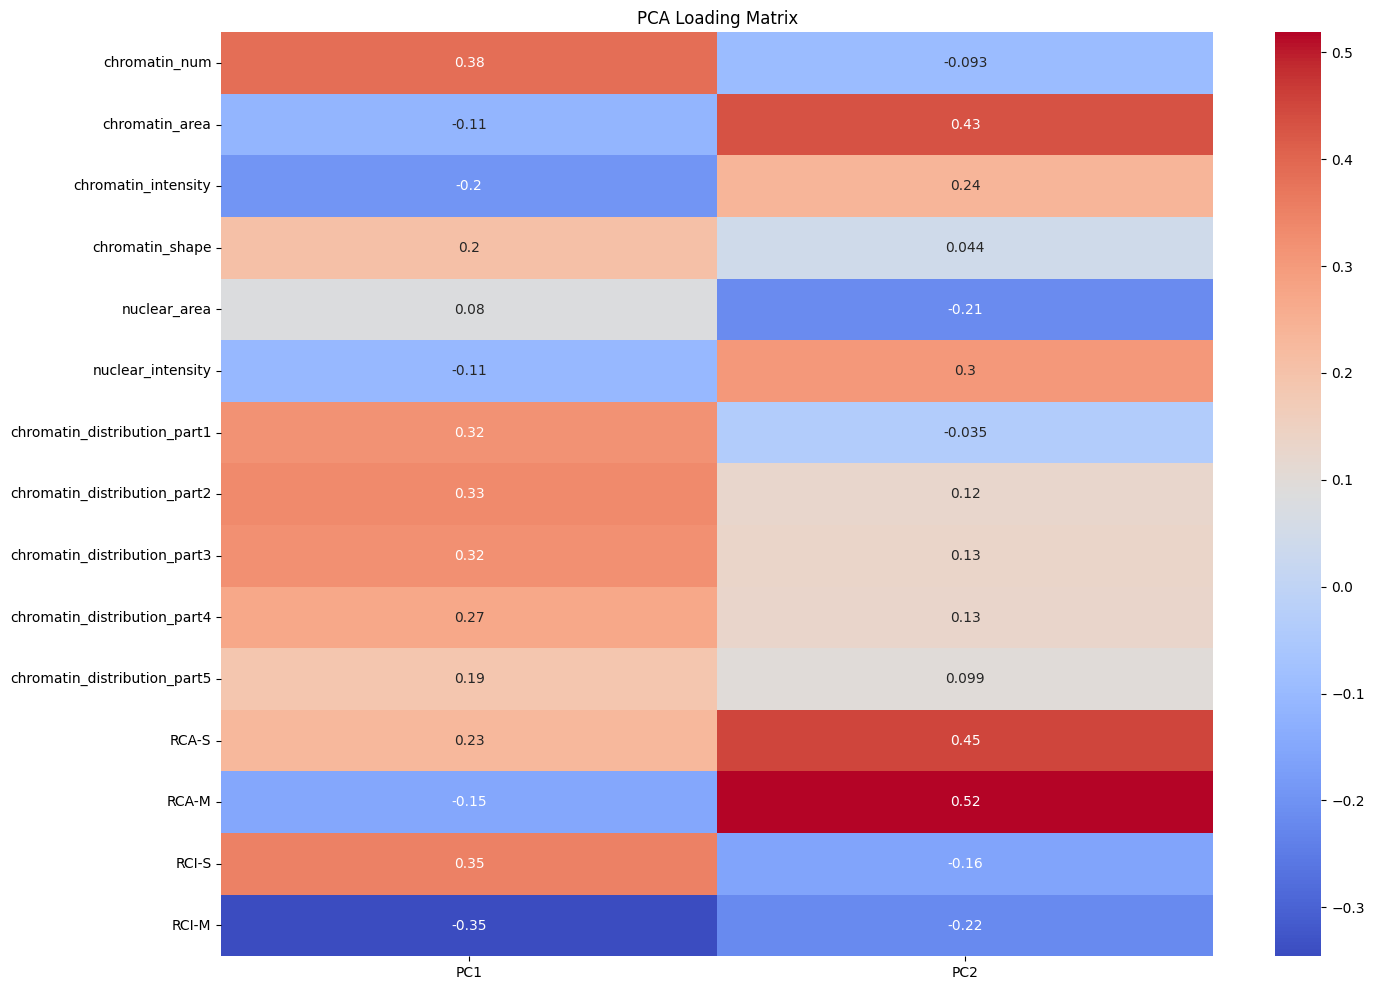

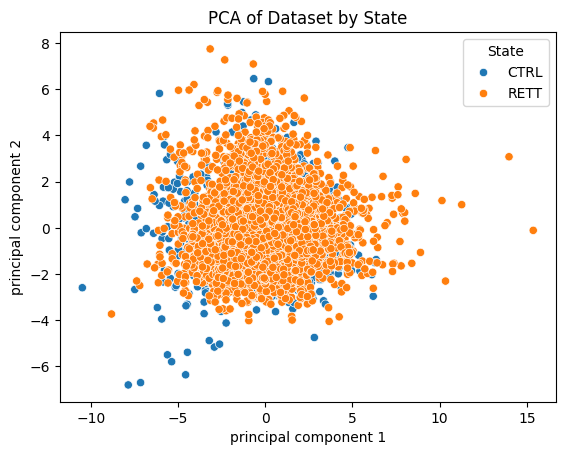

############################################################

LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/RETT_HPS9999_CTCF_metrics_basic.csv (3593, 15)
LOAD /home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR/CTRL_CTCF_metrics_basic.csv (1722, 15)
📊 PCA
Explained variance ratio: [0.29379049 0.2279607 ]


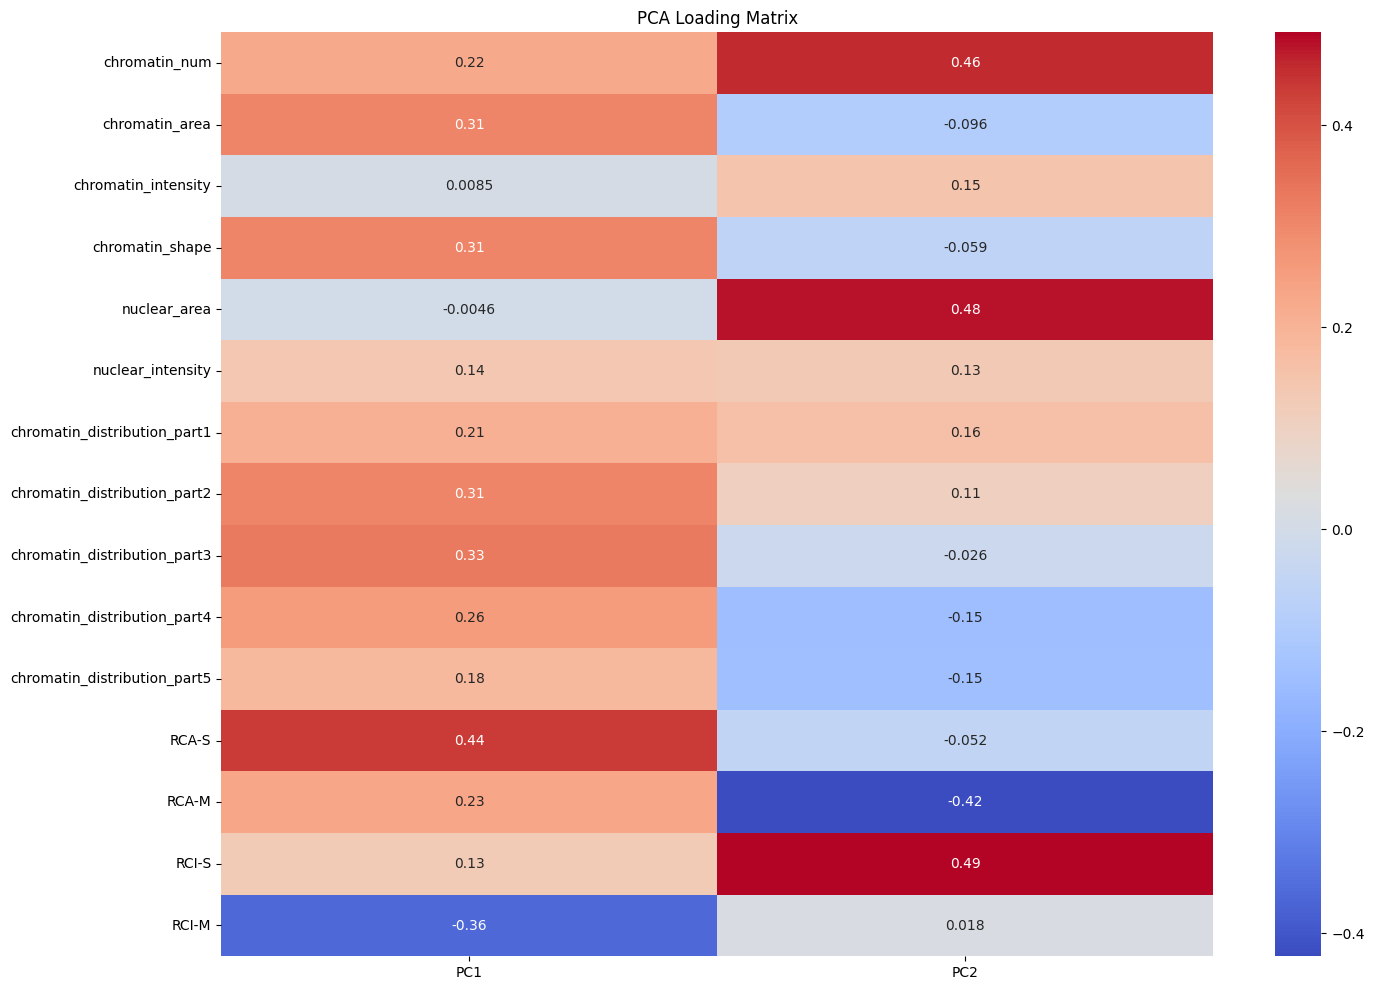

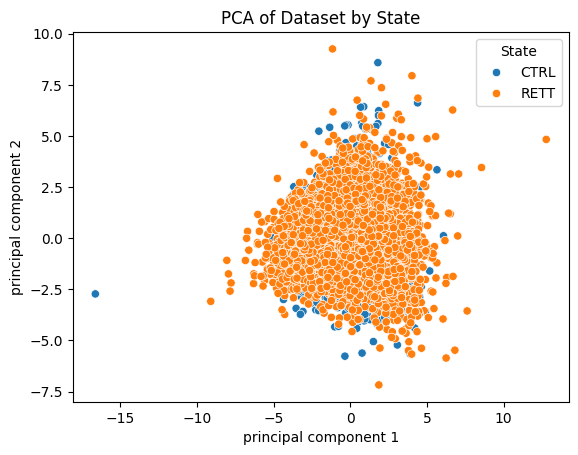

############################################################



In [15]:
# PCA
for stain_type in ["H3K27ac", "CTCF"]:

    loadpath = "/home/acd13264yb/WorkSpace/disease_epigenome/results_RTT/Biomarker/results_SR"
    loadpath_RETT = f"{loadpath}/RETT_HPS9999_{stain_type}_metrics_basic.csv"
    loadpath_CTRL = f"{loadpath}/CTRL_{stain_type}_metrics_basic.csv"

    df_combined, df_RETT, df_CTRL = loadcsv_Standard(loadpath_RETT, loadpath_CTRL)
    
    validate_pca(df_combined, df_RETT, df_CTRL)
    
    print("############################################################")
    print("")